In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

#Imports the google drive
from google.colab import drive
drive.mount('/content/drive')

import os
if os.path.exists("drive/Shared drives/COSC-480/COSC-480 Project/Sprint 1/blkjckhands.csv") == True:
  os.chdir("drive/Shared drives/COSC-480/COSC-480 Project/Sprint 1")

Mounted at /content/drive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Added: Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Added: Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_ds = datasets.ImageFolder(root="train", transform=train_transform)
test_ds = datasets.ImageFolder(root="test", transform=test_transform)
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        # self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32 * 28 * 28, 128) # This input size is now consistent with 224x224 image size
        self.fc2 = nn.Linear(128, len(train_ds.classes))
    def forward(self, x):
        x = self.pool(self.batchnorm1(self.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(self.relu(self.conv2(x))))
        x = self.pool(self.batchnorm3(self.relu(self.conv3(x))))
        # x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Using device: cuda


In [3]:
model = CNN().to(device)
model.load_state_dict(torch.load('trained_cnn.pth'))

<All keys matched successfully>

In [4]:
# Adapted from Lecture 8 Code
# The MLP that is trained on 3 cards and if the player wins or loses

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import pandas as pd

#Reads the correct CSV file inside the shared drive
df = pd.read_csv('blkjckhands.csv')

# Filter out rows where 'winloss' is 'Push'
df = df[df['winloss'] != 'Push']

 #Determine if player hit or stood (based on if card3–card5 exist)
df["action"] = df.apply(
    lambda x: "hit" if (x["card3"] > 0 or x["card4"] > 0 or x["card5"] > 0) else "stand",
    axis=1
)

# Encode three-class outcome:
# 0 = dealer wins, 1 = player stands and wins, 2 = player hits and wins
def encode_outcome(row):
    if row["winloss"] == "Loss":
        return 0
    elif row["action"] == "stand":
        return 1
    else:
        return 2

df["outcome_label"] = df.apply(encode_outcome, axis=1)

# Optionally filter dataset size (for speed)
df = df.sample(10000, random_state=42)

# Prepare input features and labels
X = df[['card1', 'card2', 'dealcard1']].values.tolist()
y = df['outcome_label'].values.tolist()

                                                     ## 20% of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) # uses mean and standard deviation of the data to move the data
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long) # Long used because other functions will be expecting it

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

input_size = X_train.shape[1]  # 3
hidden_size = 8
num_classes = 3  # dealer win, stand win, hit win
model = MLP(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()

#Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr = 0.001)

batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

#30 epochs was randomly assigned for now but seems to give similar results to 100
num_epochs = 30
for epoch in range(num_epochs):
  for batch_X, batch_y in train_loader: # Process each batch separately

    # Forward pass
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
with torch.no_grad():
  outputs = model(X_test)
  _, predicted = torch.max(outputs, 1)

accuracy = accuracy_score(y_test, predicted)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch [10/30], Loss: 0.6596
Epoch [20/30], Loss: 0.5779
Epoch [30/30], Loss: 0.5119
Accuracy: 66.70%


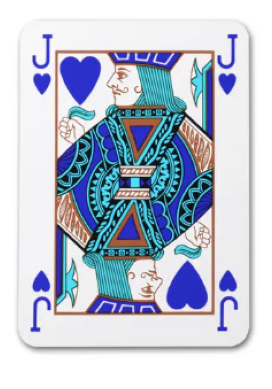

Predicted class: jack
Predicted number: 10


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

imagePath = 'uploaded images for manual testing/J.png'

imageTaken = Image.open(imagePath)
# Convert the image to RGB to ensure 3 channels
imageTaken = imageTaken.convert("RGB")

img = cv2.imread(imagePath)
# If img is used for display, and it might have an alpha channel, it's good practice to convert it as well if matplotlib expects 3 channels
# However, plt.imshow often handles RGBA, so we'll keep the original for display here.
plt.imshow(img)
plt.axis('off')
plt.show()

with torch.no_grad():
    image = test_transform(imageTaken).unsqueeze(0).to(device)
    # The 'model' variable was overwritten by the MLP in a previous cell.
    # Re-instantiate and load the CNN model for image classification.
    # Assuming CNN class and 'device' are defined globally or in an earlier cell.
    cnn_model_for_image_prediction = CNN().to(device)
    cnn_model_for_image_prediction.load_state_dict(torch.load('trained_cnn.pth'))
    output = cnn_model_for_image_prediction(image) # Use the correct CNN model
    _, predicted = torch.max(output, dim=1)

print(f"Predicted class: {train_ds.classes[predicted.item()]}")

#Dictionary to make turning the predicted class into a number
word_to_num = {
    "ace": 11,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "jack": 10,
    "queen": 10,
    "king": 10
}

predicted_number = word_to_num[train_ds.classes[predicted.item()]]
print(f"Predicted number: {predicted_number}")
card1 = predicted_number

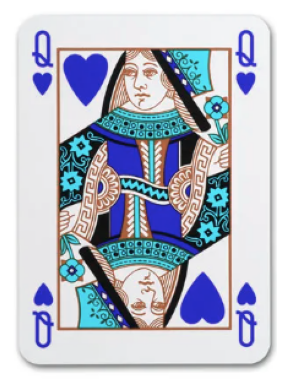

Predicted class: queen
Predicted number: 10


In [8]:
imagePath = 'uploaded images for manual testing/Q.png'

imageTaken = Image.open(imagePath)
# Convert the image to RGB to ensure 3 channels
imageTaken = imageTaken.convert("RGB")

img = cv2.imread(imagePath)
# If img is used for display, and it might have an alpha channel, it's good practice to convert it as well if matplotlib expects 3 channels
# However, plt.imshow often handles RGBA, so we'll keep the original for display here.
plt.imshow(img)
plt.axis('off')
plt.show()

with torch.no_grad():
    image = test_transform(imageTaken).unsqueeze(0).to(device)
    # The 'model' variable was overwritten by the MLP in a previous cell.
    # Re-instantiate and load the CNN model for image classification.
    # Assuming CNN class and 'device' are defined globally or in an earlier cell.
    cnn_model_for_image_prediction = CNN().to(device)
    cnn_model_for_image_prediction.load_state_dict(torch.load('trained_cnn.pth'))
    output = cnn_model_for_image_prediction(image) # Use the correct CNN model
    _, predicted = torch.max(output, dim=1)

print(f"Predicted class: {train_ds.classes[predicted.item()]}")


#Dictionary to make turning the predicted class into a number
word_to_num = {
    "ace": 11,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "jack": 10,
    "queen": 10,
    "king": 10
}

predicted_number = word_to_num[train_ds.classes[predicted.item()]]
print(f"Predicted number: {predicted_number}")
card2 = predicted_number

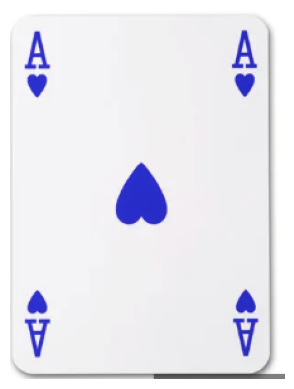

Predicted class: ace
Predicted number: 11


In [9]:
imagePath = 'uploaded images for manual testing/A.png'

imageTaken = Image.open(imagePath)
# Convert the image to RGB to ensure 3 channels
imageTaken = imageTaken.convert("RGB")


img = cv2.imread(imagePath)
# If img is used for display, and it might have an alpha channel, it's good practice to convert it as well if matplotlib expects 3 channels
# However, plt.imshow often handles RGBA, so we'll keep the original for display here.
plt.imshow(img)
plt.axis('off')
plt.show()

with torch.no_grad():
    image = test_transform(imageTaken).unsqueeze(0).to(device)
    # The 'model' variable was overwritten by the MLP in a previous cell.
    # Re-instantiate and load the CNN model for image classification.
    # Assuming CNN class and 'device' are defined globally or in an earlier cell.
    cnn_model_for_image_prediction = CNN().to(device)
    cnn_model_for_image_prediction.load_state_dict(torch.load('trained_cnn.pth'))
    output = cnn_model_for_image_prediction(image) # Use the correct CNN model
    _, predicted = torch.max(output, dim=1)

print(f"Predicted class: {train_ds.classes[predicted.item()]}")


#Dictionary to make turning the predicted class into a number
word_to_num = {
    "ace": 11,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "jack": 10,
    "queen": 10,
    "king": 10
}

predicted_number = word_to_num[train_ds.classes[predicted.item()]]
print(f"Predicted number: {predicted_number}")
dealerCard = predicted_number

In [12]:
#Gemini Helped a lot with rewriting this to fit in

import torch.nn.functional as F

#  User input
#card1 = int(input("What is your first card: "))
#card2 = int(input("What is your second card: "))
#dealerCard = int(input("What is the dealer's face up card: "))

# Prepare input for the MLP model (it expects 3 features)
# The MLP was trained to predict outcome_label (0=dealer, 1=stand win, 2=hit win)
# based on (card1, card2, dealcard1)
user_input_features = torch.tensor([[card1, card2, dealerCard]], dtype=torch.float32)

# Scale the input features
user_input_scaled = scaler.transform(user_input_features)
user_input_scaled = torch.tensor(user_input_scaled, dtype=torch.float32)

with torch.no_grad():
    outputs = model(user_input_scaled)
    probs = F.softmax(outputs, dim=1).squeeze()

# Mapping outcomes from the MLP:
# probs[0] = Probability of dealer winning
# probs[1] = Probability of player standing and winning
# probs[2] = Probability of player hitting and winning

dealer_win_prob = probs[0].item() * 100
stand_win_prob = probs[1].item() * 100
hit_win_prob = probs[2].item() * 100

#  Display nicely
print("\nPrediction based on current cards:")
print(f"{'If you STAND and win %:':25}{stand_win_prob:.1f}%")
print(f"{'If you HIT and win %:':25}{hit_win_prob:.1f}%")
print(f"{'Dealer WIN %:':25}{dealer_win_prob:.1f}%")

#  Show final decision based on win probabilities
print("\nDecision based on win probabilities:")
if stand_win_prob > hit_win_prob and stand_win_prob > dealer_win_prob:
    print("Model recommends: STAND to maximize win probability.")
elif hit_win_prob > stand_win_prob and hit_win_prob > dealer_win_prob:
    print("Model recommends: HIT to maximize win probability.")
else:
    print("Model predicts Dealer is likely to win regardless of action.")

# Original logic structure (slightly adapted to fit the correct model output for clarity):
print("\nStand Scenario Analysis:")
if stand_win_prob > dealer_win_prob:
    print("You are predicted to WIN if you stand!")
else:
    print("Dealer is predicted to win if you stand.")

print("\nHit Scenario Analysis:")
if hit_win_prob > dealer_win_prob:
    print("You are predicted to WIN if you HIT!")
else:
    print("Dealer is predicted to win if you hit.")

print("\nFinal Recommendation:")
if stand_win_prob > hit_win_prob:
    print("Model recommends: STAND (higher win probability than hitting)")
else:
    print("Model recommends: HIT (higher win probability than standing)")


Prediction based on current cards:
If you STAND and win %:  56.3%
If you HIT and win %:    0.5%
Dealer WIN %:            43.2%

Decision based on win probabilities:
Model recommends: STAND to maximize win probability.

Stand Scenario Analysis:
You are predicted to WIN if you stand!

Hit Scenario Analysis:
Dealer is predicted to win if you hit.

Final Recommendation:
Model recommends: STAND (higher win probability than hitting)
